<a href="https://colab.research.google.com/github/Kac1509/ZebrafishClassifier/blob/master/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import sys
import os
from google.colab import drive

Colab = False
if Colab:
    Script_path = '/content/gdrive/My Drive/Colab Notebooks/'
    Base_path = '/content/gdrive/My Drive/Colab Notebooks/Classifier/'
    drive.mount('/content/gdrive')
else:
    Script_path = os.getcwd() + '/Classifier/scripts'
    Base_path = 'Classifier/'
#Add script folder to system path
sys.path.insert(0, Script_path)
print(sys.path)

['C:\\Users\\Kaleem\\EPFL\\Fall 2018\\Machine Learning\\Project_2\\Git\\ZebrafishClassifier/Classifier/scripts', 'C:\\Users\\Kaleem\\EPFL\\Fall 2018\\Machine Learning\\Project_2\\Git\\ZebrafishClassifier/Classifier/scripts', '', 'C:\\Users\\Kaleem\\Anaconda3\\python36.zip', 'C:\\Users\\Kaleem\\Anaconda3\\DLLs', 'C:\\Users\\Kaleem\\Anaconda3\\lib', 'C:\\Users\\Kaleem\\Anaconda3', 'C:\\Users\\Kaleem\\AppData\\Roaming\\Python\\Python36\\site-packages', 'C:\\Users\\Kaleem\\Anaconda3\\lib\\site-packages', 'C:\\Users\\Kaleem\\Anaconda3\\lib\\site-packages\\Sphinx-1.5.6-py3.6.egg', 'C:\\Users\\Kaleem\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\Kaleem\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Kaleem\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\Kaleem\\Anaconda3\\lib\\site-packages\\setuptools-27.2.0-py3.6.egg', 'C:\\Users\\Kaleem\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Kaleem\\AppData\\Roaming\\SPB_Data\\.ipython']


In [9]:
%load_ext autoreload
%autoreload 2
from load_pre_trained_VGG16 import *
from load_pre_trained_Inception import *
from build_model_RMSprop import *
from unzip_data import *
from create_data_generators import *
from model_prediction import *
from createFolders import *
from createSets import *
from saveFiles import *
from plot_loss_acc import *
from predictClass import *




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
#Set Paths
Data_file = 'DataStraightened.zip'

Zip_path = Base_path + Data_file
Extracted_path = Base_path + 'ExtractedData/'
Partitioned_path = Base_path + 'PartitionedData/'
Prediction_path = Base_path + 'Predictions/'


In [12]:
#Specify input parameters for the pre_trained model
shapeY = 50
shapeX = 150
color_channels = 3

# Loading pre-trained models
local_weights_file_VGG16 = Base_path + 'weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model_VGG16, last_layer_output_VGG16 = load_pre_trained_VGG16(local_weights_file_VGG16, shapeY, shapeX, color_channels)


# Inception model
# local_weights_file_Inception = Base_path + '/weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
# pre_trained_model_Inception, last_layer_output_Inception = load_pre_trained_Inception(local_weights_file_Inception, shapeY, shapeX, color_channels)


In [6]:
#Clear Folders and create Prediction folder  
deleteFiles(Extracted_path)
deleteFiles(Partitioned_path)
createFolder(Prediction_path)


In [21]:
#Extract Data
unzip_data(Zip_path, Extracted_path)

In [22]:
#Create Genotype classes
Genotypes = []
num_classes = len(glob.glob(Extracted_path+'*'))
for i in range(num_classes):
        #Retrieve directory for a given type
        Genotype_name = os.listdir(Extracted_path)[i]
        Genotypes.append(Genotype(Genotype_name))
print(num_classes)
createDirectories(num_classes,Extracted_path,Partitioned_path,Genotypes)


3


<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1359x150 at 0x14012EEA7F0>


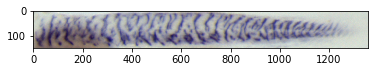

In [23]:
print(Genotypes[1].images[0])
#Genotypes[1].images
plt.imshow(Genotypes[1].images[0])

In [24]:
#Partition data into training and test set
#If fixed is true, all training and test sets have the same size for all classes 
createTrain_Test(Genotypes,0.5, fixed = True)

31
76
33


In [25]:
#Save partitions to respective folders
saveFiles(Genotypes)

In [26]:
# Creating training and validation data generators from separated data
# Transformations are for training generator only
train_generator, validation_generator = create_data_generators(
    Partitioned_path,
    shapeY, shapeX, 
    train_batch_size=12, 
    validation_batch_size=15,
    class_mode='categorical')#,
    #rotation_range=30,
    #width_shift_range=0.3,
    #height_shift_range=0.3,
    #shear_range=0.3,
    #zoom_range=0.3)

Found 48 images belonging to 3 classes.
Found 45 images belonging to 3 classes.


In [27]:
# Building model

model = build_model_RMSprop(pre_trained_model_VGG16, last_layer_output_VGG16, 
                            learning_rate = 0.00001, hidden_units_num = 1024,num_classes=num_classes,activation = 'softmax')

In [28]:
# Training model

history = model.fit_generator(
      train_generator,
      steps_per_epoch=4,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=3,
      verbose=2)

Epoch 1/10
 - 11s - loss: 0.7574 - acc: 0.5556 - val_loss: 0.6909 - val_acc: 0.5630
Epoch 2/10
 - 10s - loss: 0.6843 - acc: 0.5764 - val_loss: 0.6449 - val_acc: 0.6296
Epoch 3/10


KeyboardInterrupt: 

In [29]:
#Predict Model based on validation set
model_prediction(
    model, 
    Genotypes,
    shapeY, shapeX, 
    class_mode = 'categorical' # If the content of class0_test_path and class1_test_path should be refreshed
    )

Found 15 images belonging to 1 classes.
15/15 [==============================] - 2s 154ms/step
fsstbx6s
[[0.2401673  0.16363265 0.5962    ]
 [0.27881214 0.17138718 0.54980063]
 [0.24991502 0.17740716 0.57267785]
 [0.2377059  0.16269362 0.59960043]
 [0.28616938 0.16220658 0.551624  ]
 [0.2716726  0.19582212 0.5325052 ]
 [0.29082593 0.22101797 0.48815602]
 [0.3187704  0.16177547 0.5194541 ]
 [0.23463099 0.18295968 0.5824094 ]
 [0.28212956 0.14839275 0.5694777 ]
 [0.26144496 0.16691798 0.57163703]
 [0.296115   0.13989453 0.5639905 ]
 [0.23537365 0.20347247 0.5611538 ]
 [0.32235667 0.17283176 0.5048116 ]
 [0.30571386 0.157636   0.5366501 ]]
Found 15 images belonging to 1 classes.
15/15 [==============================] - 2s 129ms/step
her1her7s
[[0.32584798 0.15724853 0.5169035 ]
 [0.27250946 0.1469765  0.5805141 ]
 [0.33533907 0.15119433 0.51346666]
 [0.39972702 0.1086624  0.49161053]
 [0.25908926 0.2001615  0.5407492 ]
 [0.3165232  0.14519104 0.53828573]
 [0.3848617  0.13915394 0.47598428

In [30]:
#Predict Model based on Images placed in Prediction Folder
predictions = predictClass(model,Prediction_path, shapeY, shapeX, class_mode='categorical')
print(predictions)

Found 0 images belonging to 0 classes.
[]
[]


In [31]:
#Plot training and validation accuracy per epoch
plot_loss_acc(history)

NameError: name 'history' is not defined